In [21]:
# imports
import gym
import numpy as np
import math
import matplotlib.pyplot as plt

In [61]:
# chakra environment

from gym import Env
from gym.envs.registration import register
from gym.utils import seeding
from gym import spaces
import numpy as np


class chakra(Env):
    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self,mode):
        self.action_space = spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = spaces.Box(low=-1, high=1, shape=(2,))
        self.mode = mode
        self._seed()
        self.viewer = None
        self.state = None

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def _step(self, action):
        #Fill your code here
        pos = self.state
        new_pos = pos + action
        if(self.mode == 'chakra'):
            xx = 0.025
            rwd = np.sqrt(new_pos[0]*new_pos[0]+new_pos[1]*new_pos[1])
            old_rwd = np.sqrt(pos[0]*pos[0]+pos[1]*pos[1])
        elif(self.mode == 'vishamC'):
            xx = 0.01
            rwd = 0.5*pow(new_pos[0],2)+5*pow(new_pos[1],2)
            old_rwd = 0.5*pow(pos[0],2)+5*pow(pos[1],2)
        fin = -rwd+old_rwd
        if(new_pos[0] > 1 or new_pos[1] > 1 or new_pos[0] < -1 or new_pos[1] < -1):
            new_pos = self._reset()
            self.state = new_pos
            return new_pos,fin,False,{}
        elif((rwd < xx)or(new_pos[0] == 0 and new_pos[1] == 0)):
            return new_pos,0,True,{}
        else:
            self.state = new_pos
            return new_pos,fin,False,{}
    # Return the next state and the reward, along with 2 additional quantities : False, {}

    def _reset(self):
        while True:
            self.state = self.np_random.uniform(low=-1, high=1, size=(2,))
            # Sample states that are far away
            if np.linalg.norm(self.state) > 0.9:
                break
        return np.array(self.state)

    # method for rendering

    def _render(self, mode='human', close=False):
        if close:
            if self.viewer is not None:
                self.viewer.close()
                self.viewer = None
            return

        screen_width = 800
        screen_height = 800

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)

            agent = rendering.make_circle(
                min(screen_height, screen_width) * 0.03)
            origin = rendering.make_circle(
                min(screen_height, screen_width) * 0.03)
            trans = rendering.Transform(translation=(0, 0))
            agent.add_attr(trans)
            self.trans = trans
            agent.set_color(1, 0, 0)
            origin.set_color(0, 0, 0)
            origin.add_attr(rendering.Transform(
                translation=(screen_width // 2, screen_height // 2)))
            self.viewer.add_geom(agent)
            self.viewer.add_geom(origin)

        # self.trans.set_translation(0, 0)
        self.trans.set_translation(
            (self.state[0] + 1) / 2 * screen_width,
            (self.state[1] + 1) / 2 * screen_height,
        )

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

In [ ]:
# roll out

def include_bias(pp):
    return (1,pp[0],pp[1])
    

def chakra_get_action(theta, ob, rng=np.random):
    ob_1 = include_bias(ob)
    mean = theta.dot(ob_1)
    return rng.normal(loc=mean, scale=1.)

# Register the environment
rng = np.random.RandomState(42)
    
env = chakra('chakra')

get_action = chakra_get_action
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

env.seed(42)

# Initialize parameters
theta = rng.normal(scale=0.01, size=(action_dim, obs_dim + 1))

# while True:
#     ob = env._reset()
#     done = False
#     # Only render the first trajectory
#     # Collect a new trajectory
# one run
ob = env._reset()
done = False
rewards = []
for x in range(1000):
    action = get_action(theta, ob, rng=rng)
    next_ob, rew, done, _ = env._step(action)
    ob = next_ob
    env._render()
    rewards.append(rew)
print("Episode reward: %.2f" % np.sum(rewards))

In [70]:
# Policy Gradient Functions

def get_mu_ss(theta,state):
    ss = np.transpose([[1,state[0],state[1]]])
    mu = np.matmul(np.transpose(theta),ss)
    return mu,ss

def take_act(theta,state,clip,rng=np.random):
    mu,ss = get_mu_ss(theta,state)
    action = rng.normal(loc=mu, scale=1.)
    if(np.linalg.norm(action)>0.025):
        action = (action/np.linalg.norm(action))*0.025
    return action
    

def log_pi(action,state,theta):
    mu,ss = get_mu_ss(theta,state)
    mat = np.matmul(np.transpose(action-mu),action-mu)[0]
    val = -1*math.log(2*math.pi) - 0.5*mat
    return val

def diff_log_pi(action,state,theta):
    mu,ss = get_mu_ss(theta,state)
    var = action-mu
    return np.matmul((ss),np.transpose(var))

def take_right_act(theta,state,clip):
    mu,ss = get_mu_ss(theta,state)
    action = mu
    if(np.linalg.norm(action)>clip):
        action = (action/np.linalg.norm(action))*clip
    return action
    
def base_val(state):
    # write it
    return 0

In [62]:
# policy gradient algo.

max_iter = 30
batch_size = 20
step_limit = 1000
ALPHA = 0.05
GAMMA = 0.99

envP = chakra('chakra')
envP.seed(42)

obs_dim = envP.observation_space.shape[0]
action_dim = envP.action_space.shape[0]
rng = np.random.RandomState(42)
theta = rng.normal(scale=0.01, size=(obs_dim + 1,action_dim))


ep_rwd = []
ep_sts = []

for itr in range(max_iter):
    # collect trajectory and store cum. returns
    ep_itr_rwd = []
    ep_itr_sts = []
    n_samp_grad = 0
    for n_samples in range(batch_size):
        # new trajectory
        done = False
        ob = envP._reset()
        rewards = []
        acts = []
        stats = []
        
        tot = 0
        sts = 0
        for i in range(step_limit):
            action = take_act(theta,ob,0.025,rng)
            next_ob, rwd, done, _ = envP._step(action.flatten())
            # envP._render()
            rewards.append(rwd)
            tot += rwd
            acts.append(action)
            stats.append(ob)
            ob = next_ob
            sts += 1
            if(done):
                break
        print(tot,sts)
        ep_itr_sts.append(sts)
        ep_itr_rwd.append(tot)
        T = len(acts) - 1
        grad = 0
        for t in range(T + 1):
            Rt = 0
            ii = 1
            for u in range(t,T+1):
                Rt += (ii*rewards[u])
                ii = ii*GAMMA
            At = Rt - base_val(stats[t])
            grad += (diff_log_pi(acts[t],stats[t],theta)*At)
        grad = grad / (np.linalg.norm(grad) + 1e-8)
        
        n_samp_grad += (grad)
    
    ep_rwd.append(ep_itr_rwd)
    ep_sts.append(ep_itr_sts)
    theta = theta + (ALPHA/batch_size)*n_samp_grad
    print("iteration:"+str(itr))
    print("Avg rwd:"+str(np.mean(ep_itr_rwd)))
    print("Num steps:"+str(np.mean(ep_itr_sts)))
    print("theta:")
    print(theta)

0.682573609124474 1000
-0.701701816580967 1000
-0.6604348831998055 1000
0.41189344489782065 1000
-0.573338464659565 1000
-0.030666199097333813 1000
-0.051035473789215746 1000
-0.44421782538817334 1000
0.2702759977455441 1000
-0.22241999917206834 1000
-0.06488757506519405 1000
-0.4062197038451748 1000
-0.5501479919668054 1000
-0.4098907379304806 1000
-0.10871740978454247 1000
-0.389972337814377 1000
-0.5958440378799981 1000
0.18745615767469098 1000
-0.0353086895916378 1000
0.35211989757182904 1000
iteration:0
Avg rwd:-0.167024201937549
Num steps:1000.0
theta:
[[ 0.01307905  0.00414127]
 [-0.00251991  0.01995321]
 [-0.00295211 -0.01008319]]
-0.10450572690686877 1000
0.564278841428476 1000
5.9095620834474465 993
-0.30425998116698894 1000
-1.2943831925418867 1000
-0.30545904824575343 1000
0.6793130013184729 1000
-0.08449684710214694 1000
-1.032676706094959 1000
-0.1211209461452123 1000
-0.7209302618826327 1000
0.5902311441410263 1000
-0.3270575447717161 1000
0.7039286059076053 1000
-0.2725

-0.4500456111990634 1000
0.17695181066111 1000
iteration:12
Avg rwd:-0.3643131605824023
Num steps:1000.0
theta:
[[0.1244193  0.12539747]
 [0.04535264 0.08271893]
 [0.07294166 0.04018986]]
0.46996060219160973 1000
-0.1529988700480952 1000
-1.0298987990779325 1000
0.010032284613532227 1000
-0.1690132109825231 1000
-0.6254155359402542 1000
-0.3764539515513066 1000
-0.4849057228071304 1000
-0.7644725402206068 1000
-1.4714254559037325 1000
-1.8588941010918618 1000
-1.019845161551115 1000
-0.5169488900701878 1000
5.721345106826128 538
-1.2999408274455986 1000
-0.2526410950235811 1000
-0.8211968687844935 1000
-0.33921872083546944 1000
-0.9967559479433099 1000
-0.8708094285646122 1000
iteration:13
Avg rwd:-0.342474856710527
Num steps:976.9
theta:
[[0.14726011 0.14787081]
 [0.05193546 0.09152605]
 [0.08457534 0.04948358]]
-1.1580284432393373 1000
-0.6069241688239749 1000
-1.2248120155627948 1000
-0.44137860858153655 1000
0.0089595411686344 1000
0.48969670231536855 1000
6.004642687727088 354
-0.

-0.20854025309864566 1000
-1.8310979839715569 1000
iteration:25
Avg rwd:0.10456113537709477
Num steps:910.55
theta:
[[0.38859222 0.38770919]
 [0.17187785 0.22083093]
 [0.23090821 0.18485092]]
-0.43518626737883326 1000
-1.2540335993535194 1000
-0.5939574931186895 1000
6.1555511581826 143
-0.2680218551775695 1000
-2.402711884546528 1000
-0.4960972012954714 1000
0.292596741295004 1000
-2.0958052879797715 1000
4.734431930378889 843
-2.1043619441244985 1000
-0.9153884948829968 1000
-0.785394182051053 1000
-1.6885869621594907 1000
-1.4766941952310744 1000
5.966450142775094 132
-2.3719431739933627 1000
-1.4681160709304444 1000
-0.10303796492997236 1000
-0.5133111852190667 1000
iteration:26
Avg rwd:-0.09118088948703776
Num steps:905.9
theta:
[[0.40998982 0.40912809]
 [0.18188891 0.23148335]
 [0.24131868 0.19467095]]
-0.24629081032404965 1000
-0.5522224929800419 1000
-1.1330981335426449 1000
-0.44382753562266203 1000
-1.267625404756021 1000
-0.2590576397169691 1000
-1.5273970821226233 1000
6.18

In [59]:
theta_op = theta

In [131]:
done = False
tot = 0
sts = 0
ob = envP._reset()
post = [ob]
while(not done):
        action = take_right_act(theta_op,ob,0.025)
        next_ob, rwd, done, _ = envP._step(action.flatten())
        #print(next_ob)
        #envP._render()
        tot += rwd
        sts += 1
        ob = next_ob
        post.append(ob)
print(tot,sts)

5.320840029436236 137


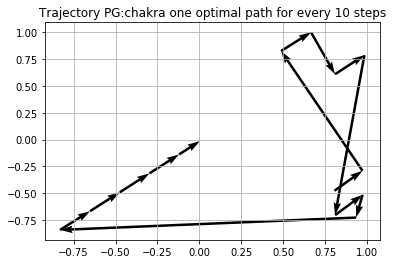

In [132]:
jump = 10
p = jump
prev = post[0]
plt.title("Trajectory PG:chakra one optimal path for every 10 steps")
plt.grid(True)
while(p < len(post)):
    pres = post[p]
    plt.quiver(prev[0],prev[1],pres[0]-prev[0],pres[1]-prev[1],angles='xy',scale_units='xy',scale=1.)
    prev = pres
    p += jump
pres = post[-1]
plt.quiver(prev[0],prev[1],pres[0]-prev[0],pres[1]-prev[1],angles='xy',scale_units='xy',scale=1.)
plt.show()

In [142]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
pol = PolynomialFeatures(degree=2)

V = {}
step_limit = 10000
for j in range(10):
    rewards = []
    stats = []
    acts = []
    ob = envP._reset()
    for i in range(step_limit):
        action = take_right_act(theta,ob,0.025)
        next_ob, rwd, done, _ = envP._step(action.flatten())
        rewards.append(rwd)
        acts.append(action)
        stats.append(ob)
        ob = next_ob
        #print(ob)
        if(done):
            break
    print(len(stats))
    T = len(acts) - 1
    for t in range(T + 1):
        Rt = 0
        ii = 1
        for u in range(t,T+1):
            Rt += (ii*rewards[u])
            ii = ii*GAMMA
        V[stats[t][0],stats[t][1]] = Rt


1876
1648
562
71
1617
457
4583
3146
856
508


In [143]:
X = [[a[0],a[1]]for a,b in V.items()]
y = [[b]for a,b in V.items()]
X = pol.fit_transform(X)
clf = linear_model.LinearRegression()
clf.fit(X,y)
co = clf.coef_

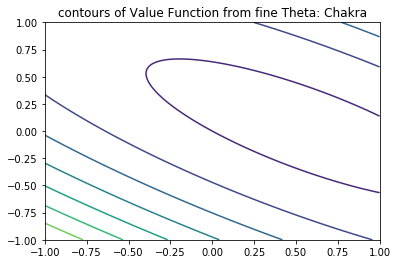

In [144]:
xlist = np.linspace(-1, 1, 100)
ylist = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(xlist, ylist)

Z = co[0][0] + co[0][1]*X + co[0][2]*Y + co[0][3]*X*Y + co[0][4]*X*X + co[0][5]*Y*Y
plt.title('contours of Value Function from fine Theta: Chakra')
plt.contour(X,Y,Z)

array([[0.47115905, 0.47017339],
       [0.20691526, 0.25759235],
       [0.270845  , 0.22275856]])